In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import pydeck as pdk
#from shapely.geometry import Polygon, mapping
#import pdb
%matplotlib inline

In [4]:
#pydeck must be >= v0.4.0 to plot geopandas data
pdk.__version__ >= '0.4.0'

True

*Note:* Will need a (free) Mapbox API key to run this yourself (see here for details https://deckgl.readthedocs.io/en/latest/installation.html)

## Load Data

In [5]:
df_legs = pd.read_csv(r'..\data\interim\legs.csv', dtype = {'VORIHORAINI':str, 'VDESHORAFIN':str})
df_trips = pd.read_csv(r'..\data\interim\trips.csv', dtype = {'VORIHORAINI':str, 'VDESHORAFIN':str})
df_people = pd.read_csv(r'..\data\interim\people.csv', dtype = {'VORIHORAINI':str, 'VDESHORAFIN':str})

codes = pd.read_csv(r'..\data\processed\codes_translated.csv', dtype = {'CODE': float})

## Load geospatial data

In [6]:
zones=gpd.read_file('..\\data\\raw\\zt84\\ZonificacionZT84.shp')
zones_merged=gpd.read_file('..\\data\\raw\\zt_merged\\zones_merged.shp')
#Spatial data must be in WGS84 for use in pydeck
zones=zones.to_crs(epsg=4326)

#Code from Alex's geospatial notebook
zones["category"] = zones.CD_ZT84.round(decimals = -4)

# assign zones to category
zones.loc[zones.CD_ZT84 <= 7907, "category"] = "Almendra"
zones.loc[zones.category == 10000, "category"] = "Periferia"
zones.loc[zones.category == 30000, "category"] = "Metropolitana"
zones.loc[zones.category == 100000, "category"] = "Corona Regional"
zones.loc[zones.CD_ZT84 == 28013, "category"] = "Corona Regional"

zones.head()

FID   D_R  CD_ZT84        ZT84    SHAPE_Leng    SHAPE_Area  \
0    1  None   7901.0      Centro  13478.747043  9.014924e+06   
1    2  None   7902.0  Arganzuela  17090.632370  1.119803e+07   
2    3  None   7903.0      Retiro  12528.412820  9.345193e+06   
3    4  None   7904.0   Salamanca  14247.801547  9.288595e+06   
4    5  None   7905.0   Chamartin  17618.706256  1.579333e+07   

                                            geometry  category  
0  POLYGON ((-3.71224 40.43023, -3.71214 40.43022...  Almendra  
1  POLYGON ((-3.70303 40.40507, -3.70255 40.40506...  Almendra  
2  POLYGON ((-3.66397 40.40886, -3.66397 40.40885...  Almendra  
3  POLYGON ((-3.68872 40.43499, -3.68868 40.43500...  Almendra  
4  POLYGON ((-3.67369 40.48285, -3.67379 40.48218...  Almendra

In [7]:
#Set colours for each category
def colour_scale(val):
    if val == "Almendra":
        return [62, 68, 183]
    elif val == "Periferia":
        return [55, 130, 55]
    elif val == "Metropolitana":
        return [239, 76, 182]
    return [242, 9, 71]

zones['fill_colour']=zones['category'].apply(lambda row: colour_scale(row))

zones.head()

FID   D_R  CD_ZT84        ZT84    SHAPE_Leng    SHAPE_Area  \
0    1  None   7901.0      Centro  13478.747043  9.014924e+06   
1    2  None   7902.0  Arganzuela  17090.632370  1.119803e+07   
2    3  None   7903.0      Retiro  12528.412820  9.345193e+06   
3    4  None   7904.0   Salamanca  14247.801547  9.288595e+06   
4    5  None   7905.0   Chamartin  17618.706256  1.579333e+07   

                                            geometry  category    fill_colour  
0  POLYGON ((-3.71224 40.43023, -3.71214 40.43022...  Almendra  [62, 68, 183]  
1  POLYGON ((-3.70303 40.40507, -3.70255 40.40506...  Almendra  [62, 68, 183]  
2  POLYGON ((-3.66397 40.40886, -3.66397 40.40885...  Almendra  [62, 68, 183]  
3  POLYGON ((-3.68872 40.43499, -3.68868 40.43500...  Almendra  [62, 68, 183]  
4  POLYGON ((-3.67369 40.48285, -3.67379 40.48218...  Almendra  [62, 68, 183]

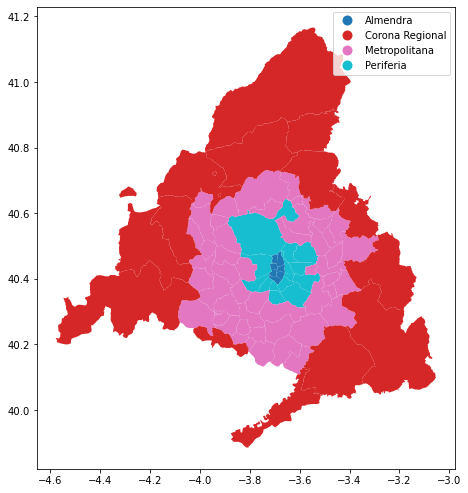

In [8]:
#Basic plot (for comparison with pydeck)
zones.plot(column = "category", figsize = (7.5, 10), legend = True)

## Convert 1259 in trip data into 84 region codes

In [10]:
df_people.head()

ID_HOGAR  ID_IND  CODMUNI  NOMMUNI  CODPROV NOMPROV   ZT1259  CZ208  \
0       189       1        2  AJALVIR       28  MADRID  002-002     60   
1       189       2        2  AJALVIR       28  MADRID  002-002     60   
2       244       1        2  AJALVIR       28  MADRID  002-002     60   
3       244       2        2  AJALVIR       28  MADRID  002-002     60   
4       324       1        2  AJALVIR       28  MADRID  002-002     60   

   ELE_HOGAR_NUEVO TIPO_ENCUESTA_hog  ...  C14ABONO  DDIA  DMES  DANNO  \
0        69.902334              CAPI  ...       NaN    25     4   2018   
1        69.902334              CAPI  ...       1.0    25     4   2018   
2        67.889119              CAPI  ...       NaN    26     4   2018   
3        67.889119              CAPI  ...       2.0    26     4   2018   
4        79.174900              CAPI  ...       NaN    25     4   2018   

   DIASEM  DNOVIAJO  C11ZT1259  C12ZT1259  CPMR  TIPO_ENCUESTA_ind  
0       3       NaN   104-001B        NaN     2               CAPI  
1       3       2.0        NaN        NaN     2               CAPI  
2       4       NaN   104-001B        NaN     2               CAPI  
3       4       NaN        NaN        NaN     2               CAPI  
4       3       NaN        NaN        NaN     2               CAPI  

[5 rows x 51 columns]

In [19]:
#Convert zones to 84 (takes 2-3min on Windows 10, core i7 2.80GHz)
df_subset=df_people

def recode_zone(val):
    return zones_merged.loc[zones_merged.ZT1259 == val].iloc[0]['CD_ZT84']

%time df_subset['CD_ZT84']=df_subset['ZT1259'].apply(lambda row: recode_zone(row))

Wall time: 3min 23s


In [39]:
df_subset.head()

ID_HOGAR  ID_IND  CODMUNI  NOMMUNI  CODPROV NOMPROV   ZT1259  CZ208  \
0       189       1        2  AJALVIR       28  MADRID  002-002     60   
1       189       2        2  AJALVIR       28  MADRID  002-002     60   
2       244       1        2  AJALVIR       28  MADRID  002-002     60   
3       244       2        2  AJALVIR       28  MADRID  002-002     60   
4       324       1        2  AJALVIR       28  MADRID  002-002     60   

   ELE_HOGAR_NUEVO TIPO_ENCUESTA_hog  ...  DMES  DANNO  DIASEM  DNOVIAJO  \
0        69.902334              CAPI  ...     4   2018       3       NaN   
1        69.902334              CAPI  ...     4   2018       3       2.0   
2        67.889119              CAPI  ...     4   2018       4       NaN   
3        67.889119              CAPI  ...     4   2018       4       NaN   
4        79.174900              CAPI  ...     4   2018       3       NaN   

   C11ZT1259  C12ZT1259  CPMR  TIPO_ENCUESTA_ind  region_code  CD_ZT84  
0   104-001B        NaN     2               CAPI      28002.0  28002.0  
1        NaN        NaN     2               CAPI      28002.0  28002.0  
2   104-001B        NaN     2               CAPI      28002.0  28002.0  
3        NaN        NaN     2               CAPI      28002.0  28002.0  
4        NaN        NaN     2               CAPI      28002.0  28002.0  

[5 rows x 53 columns]

In [34]:
#Create summary statistic in each region
region_summary=(df_subset
 .groupby(["ID_HOGAR"])
 .first()
 .reset_index()
 .groupby(["CD_ZT84"])
 [['A1PER', 'A2PER4', 'N_MIEMBROS_POR_HOGAR', 'N_VIAJES_POR_HOGAR']]
 .mean()
 .reset_index())

region_summary['CD_ZT84']=region_summary['CD_ZT84'].astype(int).astype(str)
zones['CD_ZT84']=zones['CD_ZT84'].astype(int).astype(str)

In [49]:
#Merge summary data from trips into spatial data
plot_data=(zones.merge(region_summary, on='CD_ZT84', how='left'))
plot_data.head()

FID   D_R CD_ZT84        ZT84    SHAPE_Leng    SHAPE_Area  \
0    1  None    7901      Centro  13478.747043  9.014924e+06   
1    2  None    7902  Arganzuela  17090.632370  1.119803e+07   
2    3  None    7903      Retiro  12528.412820  9.345193e+06   
3    4  None    7904   Salamanca  14247.801547  9.288595e+06   
4    5  None    7905   Chamartin  17618.706256  1.579333e+07   

                                            geometry  category    fill_colour  \
0  POLYGON ((-3.71224 40.43023, -3.71214 40.43022...  Almendra  [62, 68, 183]   
1  POLYGON ((-3.70303 40.40507, -3.70255 40.40506...  Almendra  [62, 68, 183]   
2  POLYGON ((-3.66397 40.40886, -3.66397 40.40885...  Almendra  [62, 68, 183]   
3  POLYGON ((-3.68872 40.43499, -3.68868 40.43500...  Almendra  [62, 68, 183]   
4  POLYGON ((-3.67369 40.48285, -3.67379 40.48218...  Almendra  [62, 68, 183]   

      A1PER    A2PER4  N_MIEMBROS_POR_HOGAR  N_VIAJES_POR_HOGAR  
0  2.436846  2.371681              1.304907            3.306516  
1  2.777296  2.671728              1.339841            3.445409  
2  2.690087  2.639076              1.365736            3.580366  
3  2.714644  2.643515              1.348117            3.631799  
4  2.787184  2.722310              1.420886            3.922468

### Test plotting with pydeck

In [69]:
#Create the polygon layer
layer = pdk.Layer(
    #Specify layer type (use GeoJsonLayer type when using geopandas data)
    type="GeoJsonLayer",
    #Specify object with data
    data=plot_data,
    #Fill polygons
    #Use category fill colours defined above
    filled=True,
    get_fill_color="fill_colour",
    #Give polygons different elevations
    #Elevation is relative to number of people per household
    extruded=True,
    get_elevation="A1PER*1000",
    #Add black lines around elevated polygons
    wireframe=True,
    get_line_color=[0, 0, 0],
    #Add highlighting and tooltips when you hover over polygons
    auto_highlight=True,
    pickable=True
)

#Define the starting view of the map
view = pdk.ViewState(
    #Specify centre of view
    longitude=-3.70,
    latitude=40.41,
    #Specify starting zoom (required)
    zoom=7,
    #Set pitch (use > 0 so that we can see the elevationn)
    pitch = 60)

#Combine layer and view
r = pdk.Deck(
    layer,
    initial_view_state=view,
    #Define how tooltips are displayed
    tooltip={"text": "Category: {category} \n Mean people per household: {A1PER}"}
)

r.to_html("pydeck_test.html")